## Data 100 Final Project: COVID 19 Dataset


In [66]:
import numpy as np
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.base import clone
from sklearn.model_selection import cross_val_score

import plotly.offline as py
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff

#Import Datasets
counties = pd.read_csv('abridged_couties.csv')
deaths = pd.read_csv('time_series_covid19_deaths_US.csv')
cases = pd.read_csv('time_series_covid19_confirmed_US.csv')
states = pd.read_csv('4.18states.csv')

## Data Cleaning on COVID Datasets

### States Dataframe

For data cleaning, a good starting point is to check for null and missing values and interpret what they may mean, before replacing them with any particular value.

In [67]:
# Check for how many missing values are in every column
states.isnull().sum()

Province_State           0
Country_Region           0
Last_Update             83
Lat                      5
Long_                    5
Confirmed                0
Deaths                   0
Recovered               24
Active                   1
FIPS                    82
Incident_Rate            5
People_Tested           84
People_Hospitalized     91
Mortality_Rate           3
UID                      0
ISO3                     0
Testing_Rate            84
Hospitalization_Rate    91
dtype: int64

Replacing information like People_Hospitalized with zero may not be a great idea since we cannot assume there are no people hospitalized, hence, we can replace these missing values with the mean of that country in which specific state data is missing. We can tackle People_Hospitalized, Testing_Rate, Hospitalization_Rate, People_Tested in this way.

The cell below calculates how many of the total values for each country are not missing. If a value turns out to be zero that means all data points in People_Hospitalized is missing for that country.

In [68]:
countries = states['Country_Region'].value_counts().index.tolist()
people_hospitalization_country_nulls = {}
def usable_vals(col):
    dic = {}
    for country in countries:
           dic[country] = len(states.loc[states['Country_Region'] == country,col].isnull()) - sum(states.loc[states['Country_Region'] == country,col].isnull())
    return dic
People_Hospitalization_country_nulls = usable_vals('People_Hospitalized')
Hospitalization_Rate_country_nulls = usable_vals('Hospitalization_Rate')
print(Hospitalization_Rate_country_nulls == People_Hospitalization_country_nulls)
print('People_Hospitalized \n', usable_vals('People_Hospitalized'))
print('Hospitalization_Rate \n', usable_vals('Hospitalization_Rate'))
print('Testing_Rate \n', usable_vals('Testing_Rate'))
print('People Tested \n', usable_vals('People_Tested'))
print('Mortality Rate \n', usable_vals('Mortality_Rate'))

True
People_Hospitalized 
 {'US': 49, 'China': 0, 'Canada': 0, 'France': 0, 'United Kingdom': 0, 'Australia': 0, 'Netherlands': 0, 'Denmark': 0}
Hospitalization_Rate 
 {'US': 49, 'China': 0, 'Canada': 0, 'France': 0, 'United Kingdom': 0, 'Australia': 0, 'Netherlands': 0, 'Denmark': 0}
Testing_Rate 
 {'US': 56, 'China': 0, 'Canada': 0, 'France': 0, 'United Kingdom': 0, 'Australia': 0, 'Netherlands': 0, 'Denmark': 0}
People Tested 
 {'US': 56, 'China': 0, 'Canada': 0, 'France': 0, 'United Kingdom': 0, 'Australia': 0, 'Netherlands': 0, 'Denmark': 0}
Mortality Rate 
 {'US': 57, 'China': 33, 'Canada': 13, 'France': 10, 'United Kingdom': 10, 'Australia': 8, 'Netherlands': 4, 'Denmark': 2}


We notice that there is another null value in a country outside the US, so to see which country that is, we can instead of check the values that are not null to sum the values that are infact null.

In [69]:
mortality_dic = {}
for country in countries:
        mortality_dic[country] =  sum(states.loc[states['Country_Region'] == country,'Mortality_Rate'].isnull())
mortality_dic

{'US': 2,
 'China': 0,
 'Canada': 1,
 'France': 0,
 'United Kingdom': 0,
 'Australia': 0,
 'Netherlands': 0,
 'Denmark': 0}

Only the data for US contains values that will be usable so we can go ahead and replace the NaN values in the US data with the mean of that column in the US and from here note that we can only incorporate People_Hospitalized in analysis within the US.

In [70]:
def replace_nan_with_mean(country, col):
    arr = states.loc[states['Country_Region'] == country, col]
    arr_mean = arr.mean()
    arr.fillna(arr_mean, inplace=True)
    states.loc[states['Country_Region'] == country,col] = arr

replace_nan_with_mean('US','People_Hospitalized')
replace_nan_with_mean('US','Hospitalization_Rate')
replace_nan_with_mean('US','Testing_Rate')
replace_nan_with_mean('US','People_Tested')
replace_nan_with_mean('US','Mortality_Rate')

# There is still an uncovered NaN value in Mortality_Rate but this time in a different country so we can remove that. Namely, Canada.
replace_nan_with_mean('Canada','Mortality_Rate')

states.isnull().sum()
states.head()

Province_State Country_Region          Last_Update      Lat     Long_  \
0         Alabama             US  2020-04-18 22:32:47  32.3182  -86.9023   
1          Alaska             US  2020-04-18 22:32:47  61.3707 -152.4044   
2  American Samoa             US                  NaN -14.2710 -170.1320   
3         Arizona             US  2020-04-18 22:32:47  33.7298 -111.4312   
4        Arkansas             US  2020-04-18 22:32:47  34.9697  -92.3731   

   Confirmed  Deaths  Recovered  Active  FIPS  Incident_Rate  People_Tested  \
0       4712     153        NaN  4559.0   1.0     100.492717        42538.0   
1        314       9      147.0   305.0   2.0      52.530410         9655.0   
2          0       0        NaN     NaN  60.0       0.000000            3.0   
3       4724     180      539.0  4544.0   4.0      64.901548        51045.0   
4       1744      38      703.0  1706.0   5.0      67.361213        24141.0   

   People_Hospitalized  Mortality_Rate       UID ISO3  Testing_Rate  \
0           620.000000        3.247029  84000001  USA    907.206961   
1            39.000000        2.866242  84000002  USA   1615.226458   
2          2327.122449        3.727277        16  ASM      5.391708   
3           566.000000        3.810330  84000004  USA    701.291175   
4           291.000000        2.178899  84000005  USA    932.435235   

   Hospitalization_Rate  
0             13.157895  
1             12.420382  
2             14.141068  
3             11.981372  
4             16.685780

### Cases and Deaths DataFrames

Next, we clean the dataframes of cases and deaths. After examining the data, we first drop the rows with out of state FIPS, unassigned FIPS, correctional facilities and the Grand Princess. Then we fill in or appropriately reassign rows with missing FIPS, using data from census.gov. Next, we merge to create a dataframe containing total confirmed cases and deaths by region.

In [71]:
# Dropping out of state FIPS, unassigned FIPS, correctional facilities and the Grand Princess
cases.drop(cases.index[3149:3255], inplace = True)
deaths.drop(deaths.index[3149:3255], inplace = True)

# Replace missing FIPS for Kansas City with data from census.gov
cases.loc[cases['Admin2']=='Kansas City', 'FIPS'] = 29380.0
deaths.loc[deaths['Admin2']=='Kansas City', 'FIPS'] = 29380.0

# Duke and Nantucket Counties' numbers have been counted jointly, recorded only under 'Dukes and Nantucket'. Ideally, the counts would be redistributed evenly between Duke and Nantucket, however it is not realistic to assign 0.5 deaths to a county. Therefore, we have assigned all counts to the FIPS of Nantucket and dropped the Nantucket row. This is not an ideal solution.
cases.loc[cases['Admin2']=='Dukes and Nantucket', 'FIPS'] = 25019.0
deaths.loc[deaths['Admin2']=='Dukes and Nantucket', 'FIPS'] = 25019.0
cases.drop(cases.loc[cases['Admin2']=='Nantucket',:].index, inplace = True)
deaths.drop(deaths.loc[deaths['Admin2']=='Nantucket',:].index, inplace = True)
#deaths[deaths['FIPS'].isnull()]

# Convert to string and add padded 0 for consistency with counties data
deaths['FIPS'] = deaths['FIPS'].astype(int).astype(str).str.zfill(5)
cases['FIPS'] = cases['FIPS'].astype(int).astype(str).str.zfill(5)

# Create a dataframe with the total confirmed cases and deaths by region.
total_cases = cases[['FIPS', 'Province_State', 'Lat', 'Long_', '4/18/20']]
total_cases.rename(columns={'4/18/20':'total_confirmed'}, inplace=True)
total_deaths = deaths[['FIPS', '4/18/20']]
total_deaths.rename(columns={'4/18/20':'total_deaths'}, inplace=True)
total_by_region = total_cases.merge(total_deaths, how = 'left', on = ['FIPS'])
total_by_region.rename(columns={'Long_':'Long'}, inplace = True)
total_by_region.head(10)

# Dropping America Samoa, Guam, Northern Mariana Islands, Puerto Rico and Virgin Islands
total_by_region.drop(total_by_region.index[0:5], inplace = True)

# Adding a column with mortality rate
total_by_region['Mortality_Rate'] = total_by_region['total_deaths'] / total_by_region['total_confirmed']
total_by_region['Mortality_Rate'] = np.nan_to_num(total_by_region['Mortality_Rate'])
total_by_region.head()

FIPS Province_State        Lat       Long  total_confirmed  total_deaths  \
5  01001        Alabama  32.539527 -86.644082               25             2   
6  01003        Alabama  30.727750 -87.722071              109             2   
7  01005        Alabama  31.868263 -85.387129               18             0   
8  01007        Alabama  32.996421 -87.125115               26             0   
9  01009        Alabama  33.982109 -86.567906               20             0   

   Mortality_Rate  
5        0.080000  
6        0.018349  
7        0.000000  
8        0.000000  
9        0.000000

### County DataFrame

To look at the features of counties alongside confirmed cases and death counts, we merge the dataframes. We then examine the null values and implement appropriate cleaning. We focus our data explanation on features which may affect the mortality rates of states and countries. 

We drop the 3 rows (FIPS 02158 in Alaska, FIPS 46102 in South Dakota, and FIPS 29380 in Missouri) that have multiple null values. Although 29380 in Missouri had 412 Covid cases, we decide to drop these 3 columns as we do not have a reliable method of filling in the missing values. We then drop the columns that do not pertain to our study of mortality rates or that have so many null values that they are rendered unreliable. Counties belonging to North and South Dakota had null values for '>50 gatherings', '>500 gatherings', 'stay at home', and 'entertainment/gym'. After consulting outside sources (https://www.npr.org/2020/05/01/847413697/midwest-coronavirus-related-restrictions-by-state), we discovered this was because these states did not institute such bans and filled the values with zero. Lastly, there we filled the null values in columns 'HeartDiseaseMortality', 'StrokeMortality', and 'SVIPercentile' with the mean.

In [72]:
county_cases = total_by_region.merge(counties, how = 'left', left_on = 'FIPS', right_on = 'countyFIPS')

# There are 3 rows (FIPS 02158 in Alaska, FIPS 46102 in South Dakota, and FIPS 29380 in Missouri) that have multiple null values. Although 29380 in Missouri had 412 Covid cases, we decide to drop these 3 columns as we do not have a reliable method of filling in the missing values.
county_cases.drop(county_cases[county_cases['countyFIPS'].isnull()].index, inplace = True)

# We drop the columns that are either not of interest to our study or that have too many null values to be useful or reliable. We also drop redundant identifiers (ie countyFIPS and COUNTYFP).
county_cases.drop(['dem_to_rep_ratio', 'PopMale<52010', 'PopFmle<52010', 'PopMale5-92010', 'PopFmle5-92010', 'PopMale10-142010', 'PopFmle10-142010', 'PopMale15-192010','PopFmle15-192010', 'PopMale20-242010', 'PopFmle20-242010', 'PopMale25-292010', 'PopFmle25-292010', 'PopMale30-342010', 'PopFmle30-342010', 'PopMale35-442010', 'PopFmle35-442010', 'PopMale45-542010', 'PopFmle45-542010', 'PopMale55-592010', 'PopFmle55-592010', 'PopMale60-642010', 'PopFmle60-642010', 'PopMale65-742010', 'PopFmle65-742010', 'PopMale75-842010', 'PopFmle75-842010', 'PopMale>842010', 'PopFmle>842010', 'CensusRegionName', 'CensusDivisionName', 'Rural-UrbanContinuumCode2013', 'FracMale2017', '3-YrMortalityAge<1Year2015-17', '3-YrMortalityAge1-4Years2015-17', '3-YrMortalityAge5-14Years2015-17', '3-YrMortalityAge15-24Years2015-17', '3-YrMortalityAge25-34Years2015-17', '3-YrMortalityAge35-44Years2015-17', '3-YrMortalityAge45-54Years2015-17', '3-YrMortalityAge55-64Years2015-17', '3-YrMortalityAge65-74Years2015-17', '3-YrMortalityAge75-84Years2015-17', '3-YrMortalityAge85+Years2015-17', 'mortality2015-17Estimated', 'HPSAShortage', 'HPSAServedPop', 'HPSAUnderservedPop', '3-YrDiabetes2015-17', 'MedicareEnrollment,AgedTot2017', '#EligibleforMedicare2018', 'federal guidelines', 'foreign travel ban', 'countyFIPS', 'COUNTYFP', 'STATEFP', 'StateName', 'State', 'lat', 'lon', 'POP_LATITUDE', 'POP_LONGITUDE' ], axis = 1, inplace = True)

#The counties with null values for the date of certain bans did not institute such bans, so we filled those values with 0. (https://www.npr.org/2020/05/01/847413697/midwest-coronavirus-related-restrictions-by-state)
county_cases = county_cases.fillna({'>50 gatherings':0, '>500 gatherings':0, 'stay at home':0, 'entertainment/gym':0})

#Lastly, there are 4 columns with null values that are most appropriately accounted for by filling with mean.
county_cases['HeartDiseaseMortality'].fillna(county_cases['HeartDiseaseMortality'].mean(), inplace = True)
county_cases['StrokeMortality'].fillna(county_cases['StrokeMortality'].mean(), inplace = True)
county_cases['SVIPercentile'].fillna(county_cases['StrokeMortality'].mean(), inplace = True)
states['Recovered'].fillna(states['Recovered'].mean(), inplace = True)

# This prints the number of null values in each column.
# print('Null values in county_cases:\n')
# for column in county_cases.columns.values.tolist():
#     print(column,':', sum(county_cases[column].isnull()) )

print(list(county_cases.columns))

['FIPS', 'Province_State', 'Lat', 'Long', 'total_confirmed', 'total_deaths', 'Mortality_Rate', 'CountyName', 'PopulationEstimate2018', 'PopTotalMale2017', 'PopTotalFemale2017', 'PopulationEstimate65+2017', 'PopulationDensityperSqMile2010', 'CensusPopulation2010', 'MedianAge2010', 'DiabetesPercentage', 'HeartDiseaseMortality', 'StrokeMortality', 'Smokers_Percentage', 'RespMortalityRate2014', '#FTEHospitalTotal2017', "TotalM.D.'s,TotNon-FedandFed2017", '#HospParticipatinginNetwork2017', '#Hospitals', '#ICU_beds', 'stay at home', '>50 gatherings', '>500 gatherings', 'public schools', 'restaurant dine-in', 'entertainment/gym', 'SVIPercentile']


Now we group the county data by State to create a dataframe with the data available at the county level extended to the state level. Then we merge with the cleaned States dataframe to have the information on state level mortality, hospitalization and testing alongside information about the measures the state took and information about the state.

In [73]:
# First we aggregate the county information by state, summing counts and averaging rates and dates as appropriate.
state_cases_sum = county_cases[['Province_State','total_confirmed', 'total_deaths','PopulationEstimate2018', 'PopTotalMale2017', 'PopTotalFemale2017', 'PopulationEstimate65+2017', 'CensusPopulation2010', '#FTEHospitalTotal2017', "TotalM.D.'s,TotNon-FedandFed2017", '#HospParticipatinginNetwork2017', '#Hospitals', '#ICU_beds']].groupby(['Province_State']).sum().reset_index()

state_cases_mean = county_cases[['Province_State', 'PopulationDensityperSqMile2010','MedianAge2010', 'DiabetesPercentage', 'HeartDiseaseMortality', 'StrokeMortality', 'Smokers_Percentage', 'RespMortalityRate2014', 'stay at home', '>50 gatherings', '>500 gatherings', 'public schools', 'restaurant dine-in', 'entertainment/gym', 'SVIPercentile']].groupby(['Province_State']).mean().reset_index()

state_cases = state_cases_mean.merge(state_cases_sum, how = 'left', on = 'Province_State')

# Now we merge with the states dataframe.
state_cases = state_cases.merge(states[states['Country_Region'] == 'US'], how = 'left', on = 'Province_State')

#state_cases.head()
print(list(state_cases.columns))

['Province_State', 'PopulationDensityperSqMile2010', 'MedianAge2010', 'DiabetesPercentage', 'HeartDiseaseMortality', 'StrokeMortality', 'Smokers_Percentage', 'RespMortalityRate2014', 'stay at home', '>50 gatherings', '>500 gatherings', 'public schools', 'restaurant dine-in', 'entertainment/gym', 'SVIPercentile', 'total_confirmed', 'total_deaths', 'PopulationEstimate2018', 'PopTotalMale2017', 'PopTotalFemale2017', 'PopulationEstimate65+2017', 'CensusPopulation2010', '#FTEHospitalTotal2017', "TotalM.D.'s,TotNon-FedandFed2017", '#HospParticipatinginNetwork2017', '#Hospitals', '#ICU_beds', 'Country_Region', 'Last_Update', 'Lat', 'Long_', 'Confirmed', 'Deaths', 'Recovered', 'Active', 'FIPS', 'Incident_Rate', 'People_Tested', 'People_Hospitalized', 'Mortality_Rate', 'UID', 'ISO3', 'Testing_Rate', 'Hospitalization_Rate']


## Exploratory Data Analysis

### Counties Level Comparison in CA and NY
We wish to know which features of counties act as best predictors of mortality rate. Without the resources to thoroughly examine the counties in every state of the US, we focus on the counties in New York and California, as they are two of the largest states, yet they experienced very different impacts from COVID (https://abc7news.com/feature/health/coronavirus-how-close-was-california-to-becoming-a-new-york-level-crisis/6108354/).


In [74]:
ca_cases = county_cases.loc[(county_cases['Province_State'] == 'California') & (county_cases['total_confirmed']>0)]
ny_cases = county_cases.loc[(county_cases['Province_State'] == 'New York') & (county_cases['total_confirmed']>0)]

The columns within counties have been inputted as Gregorian ordinal, which can be converted to te more readible and comprehensible MM/DD/YYYY format built into pandas. The following columns need this change: stay at home, >50 gatherings, >500 gatherings, public schools, restaurant dine-in, entertainment/gym.

In [75]:
from datetime import date
cols = ['stay at home','>50 gatherings','>500 gatherings','public schools','restaurant dine-in','entertainment/gym']
def date_change(df,cols):
    for col in cols:
        state_dates = df[col].unique()
        for dates in state_dates:
            new_state_date = date.fromordinal(int(dates)).isoformat()
            df[col].replace(dates, new_state_date, inplace=True)
# date_change(ca_cases, cols)
# date_change(ny_cases, cols)

To focus our analysis, we group the features of counties as follows:
1. ***Population Stats***:  'PopulationEstimate2018',  'PopTotalMale2017',  'PopTotalFemale2017',   'PopulationDensityperSqMile2010'
2. ***At Risk Populations***:  'MedianAge2010', 'PopulationEstimate65+2017', 'DiabetesPercentage',  'HeartDiseaseMortality',  'StrokeMortality',  'Smokers_Percentage', 'RespMortalityRate2014'
3. ***Infrastructure* (Ability to provide care)**:  '#FTEHospitalTotal2017', "TotalM.D.'s,TotNon-FedandFed2017", '#HospParticipatinginNetwork2017', '#Hospitals', '#ICU_beds', 'SVIPercentile'

We had hoped to also examine pandemic polilcies. However, since most policies came down from a governor and impacted all counties on the same date, this was not a useful 
4. Not included in county level analysis: **Pandemic *Policies* Enacted**: 'stay at home', '>50 gatherings', '>500 gatherings', 'public schools', 'restaurant dine-in', 'entertainment/gym'

In [76]:
population_stats = ['PopulationEstimate2018', 'PopTotalMale2017', 'PopTotalFemale2017',  'PopulationDensityperSqMile2010', 'Mortality_Rate']
at_risk = ['MedianAge2010', 'PopulationEstimate65+2017', 'DiabetesPercentage',  'HeartDiseaseMortality',  'StrokeMortality',  'Smokers_Percentage', 'RespMortalityRate2014','Mortality_Rate']
infrastructure = ['#FTEHospitalTotal2017', "TotalM.D.'s,TotNon-FedandFed2017", '#HospParticipatinginNetwork2017', '#Hospitals', '#ICU_beds', 'SVIPercentile','Mortality_Rate']
#policies = ['stay at home', '>50 gatherings', '>500 gatherings', 'public schools', 'restaurant dine-in', 'entertainment/gym', 'Mortality_Rate']

### Feature Correlations:
To determine the best features to train our model on, we examine their correlations.

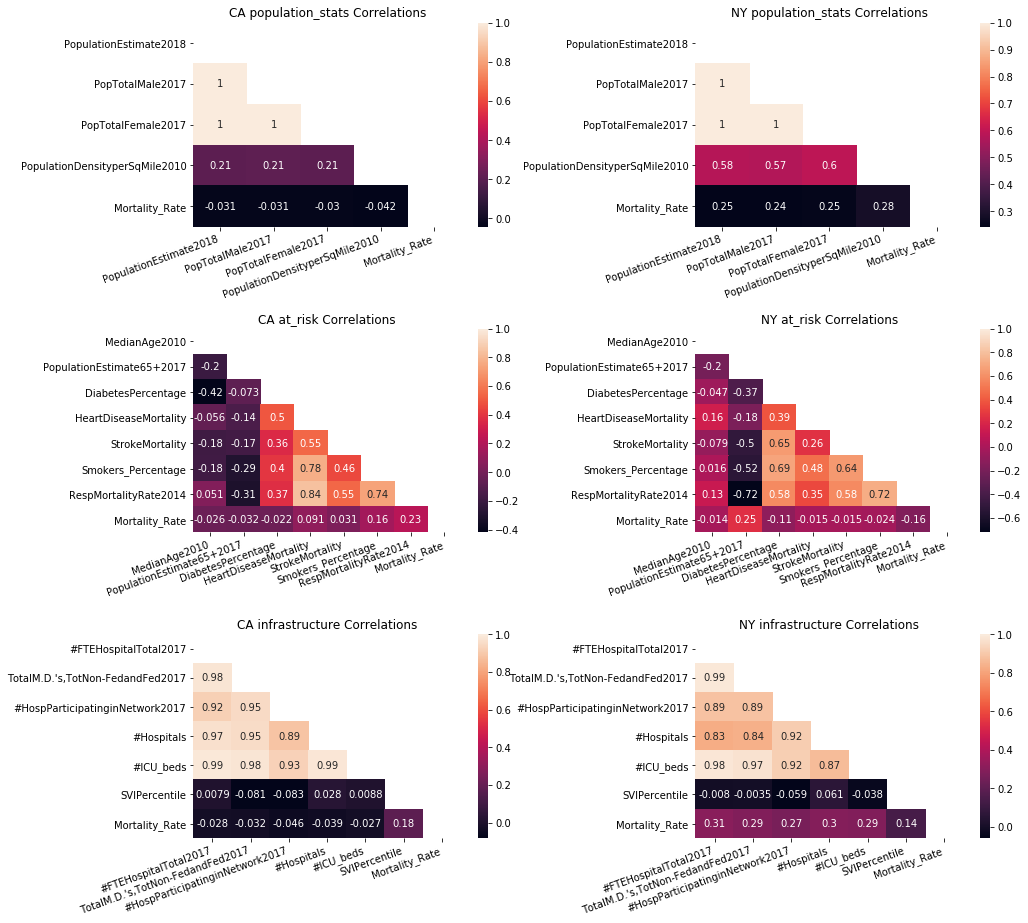

In [12]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3,2, figsize=(15, 15))
matrix = np.triu(ca_cases[population_stats].corr())
sns.heatmap(ca_cases[population_stats].corr(), ax = ax1, annot=True, mask=np.triu(ca_cases[population_stats].corr())).set_title('CA population_stats Correlations')
sns.heatmap(ny_cases[population_stats].corr(), ax = ax2, annot=True, mask=np.triu(ny_cases[population_stats].corr())).set_title('NY population_stats Correlations')
sns.heatmap(ca_cases[at_risk].corr(), ax = ax3, annot=True, mask = np.triu(ca_cases[at_risk].corr())).set_title('CA at_risk Correlations')
sns.heatmap(ny_cases[at_risk].corr(), ax = ax4, annot=True, mask=np.triu(ny_cases[at_risk].corr())).set_title('NY at_risk Correlations')
sns.heatmap(ca_cases[infrastructure].corr(), ax = ax5, annot=True, mask=np.triu(ca_cases[infrastructure].corr())).set_title('CA infrastructure Correlations')
sns.heatmap(ny_cases[infrastructure].corr(), ax = ax6, annot=True, mask=np.triu(ny_cases[infrastructure].corr())).set_title('NY infrastructure Correlations')
fig.subplots_adjust(hspace = 0.5, wspace = 0.5)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=20, horizontalalignment='right');
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=20, horizontalalignment='right');
ax3.set_xticklabels(ax3.get_xticklabels(), rotation=20, horizontalalignment='right');
ax4.set_xticklabels(ax4.get_xticklabels(), rotation=20, horizontalalignment='right');
ax5.set_xticklabels(ax5.get_xticklabels(), rotation=20, horizontalalignment='right');
ax6.set_xticklabels(ax6.get_xticklabels(), rotation=20, horizontalalignment='right');

### Update Features:
We update our features accordingly, discarding the features with little correlation to mortality rate and features with high correlation to each other. For example, we leave 'PopulationEstimate2018', but eliminate the population counts by gender. It is notable that there are significant differences between the correlations of CA infrastructure features (Total MD's, Hospitals, etc.) and those of NY. We are unclear why this is.

In [13]:
population_stats = ['PopulationEstimate2018', 'PopulationDensityperSqMile2010', 'Mortality_Rate']
at_risk = ['MedianAge2010', 'PopulationEstimate65+2017', 'DiabetesPercentage',  'HeartDiseaseMortality',  'StrokeMortality','Smokers_Percentage', 'RespMortalityRate2014','Mortality_Rate']
infrastructure = ['#FTEHospitalTotal2017', "TotalM.D.'s,TotNon-FedandFed2017", '#HospParticipatinginNetwork2017', '#Hospitals', '#ICU_beds', 'SVIPercentile','Mortality_Rate']

### Modeling Helper Functions

In [77]:
# Defines the loss we will use to evaluate our models performance
def rmse(predicted, actual):
    return np.sqrt(np.mean((actual - predicted)**2))
def rmse_score(model, X, Y):
    return np.sqrt(np.mean((Y - model.predict(X))**2))

In [78]:
# Will select the desired columns above from provided dataframe
def select_columns(data, columns): 
    return data.loc[:,columns]

# Will select and perform necessary transformations on columns to form the feature matrix and response variable 
def process_data(data, cols, metric):   
    # Select the desired columns 
    df = select_columns(data, cols)    
    # Return features matrix and response variable (X and Y)
    X = df.drop([metric], axis=1)
    Y = df.loc[:,metric]    
    return X,Y

# Will test the model by predicting the response variable and output RMSE and CV Errors
def test_models(model, X, Y):
    # Fit a Model 
    model.fit(X,Y)   
    # Predict our Response Variable (Y)
    Y_pred = model.predict(X)    
    # Test our model accuracy using RMSE 
    error = rmse(Y_pred, Y)    
    # Test our model using Cross Validation and RMSE 
    cv_error = np.mean(cross_val_score(model, X, Y, scoring=rmse_score, cv=5))       
    # return the predicted response variable, and the two errors
    return Y_pred, error, cv_error

### Population Statistics of Counties

#### California

We can check for outliers or other anomalies in our data by visualizing a few columns of the feature matrix

Text(0.5, 1.0, 'Population Statistics of California Counties')

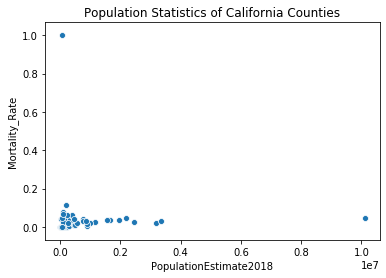

In [79]:
sns.scatterplot(ca_cases['PopulationEstimate2018'], ca_cases['Mortality_Rate'])
plt.title('Population Statistics of California Counties')

There are clear outliers here, so we can try to identify them and ponder how to deal with them

In [80]:
# isolate and identify the outliers
print(ca_cases[ca_cases['PopulationEstimate2018'] > 10000000]['CountyName'])
print(ca_cases[ca_cases['Mortality_Rate'] > 0.8]['CountyName'])

204    Los Angeles
Name: CountyName, dtype: object
237    Tehama
Name: CountyName, dtype: object


Examining Los Angeles county and crossreferencing with data from lacounty.gov, we find that it has both a high number of deaths (576 on the date our data was collected and 1,530 presently) as well as a large population. Examining Tehama county, we find that it had 1 case of Covid and 1 death, resulting in the mortality rate of 100%. Tehama county effectively provides a sample size of 1, which is not a good basis for determing mortality rate. Removing Tehama county will likely not have severe consequences. However, by removing LA county, our model will perform worse on counties with large populations. If this model were ever released for external use, it should come with a statement to that effect.

Text(0.5, 1.0, 'California- No Outliers')

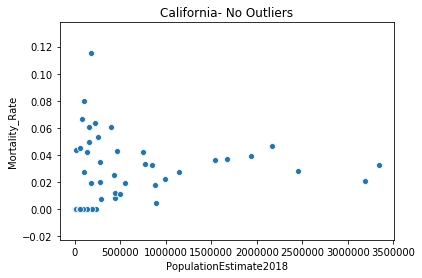

In [81]:
# We can see what the result of removing these outliers is on the visualization
ca_cases_no_outlier = ca_cases[ca_cases['PopulationEstimate2018'] < 10000000]
ca_cases_no_outlier = ca_cases_no_outlier[ca_cases_no_outlier['Mortality_Rate'] < 0.8]

sns.scatterplot(ca_cases_no_outlier['PopulationEstimate2018'], ca_cases_no_outlier['Mortality_Rate'])
plt.title('California- No Outliers')

We can test how much these two outliers affect our model performance by training a model with these outliers included and one with them removed. 

In [82]:
# Form the Feature Matrix and Response Variable 
X_ca_pop, Y_ca_pop = process_data(ca_cases, population_stats, 'Mortality_Rate')

In [83]:
# Fit the Linear Regression Model on these features (all columns have quantitative continuous data so no transformations needed)
ca_pop_model = LinearRegression(fit_intercept=True)
Y_ca_pop_pred, ca_pop_error, ca_pop_cv_error = test_models(ca_pop_model,X_ca_pop,Y_ca_pop)

# Training and CV Error
print("CA Population Stats RMSE: {}".format(ca_pop_error))
print("CA Population Stats CV RMSE: {}".format(ca_pop_cv_error))

CA Population Stats RMSE: 0.134436780081156
CA Population Stats CV RMSE: 0.11237091120401646


In [84]:
# Form the Feature Matrix and Response Variable 
X_ca_pop_no_outlier, Y_ca_pop_no_outlier = process_data(ca_cases_no_outlier, population_stats, 'Mortality_Rate')

In [85]:
# Fit the Linear Regression Model on these features with the outliers above removed
ca_pop_model_no_outlier = LinearRegression(fit_intercept=True)
Y_ca_pop_pred_no_outlier, ca_pop_error_no_outlier, ca_pop_cv_error_no_outlier = test_models(ca_pop_model_no_outlier, X_ca_pop_no_outlier, Y_ca_pop_no_outlier)

# Training and CV Error
print("CA Population Stats without Outliers RMSE: {}".format(ca_pop_error_no_outlier))
print("CA Population Stats CV without Outliers RMSE: {}".format(ca_pop_cv_error_no_outlier))

CA Population Stats without Outliers RMSE: 0.024696217231424445
CA Population Stats CV without Outliers RMSE: 0.035880296283014944


We can see that based on our RMSE errors, the set without outliers has better accuracy off the bat, so that can be a good subset of the feature matrix for our population metrics to go off of. 

#### New York

Once again, we will explore the nature of our data (anomalies)

Text(0.5, 1.0, 'Population Statistics of New York Counties')

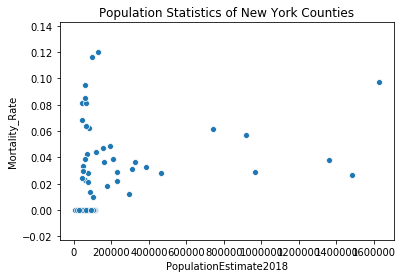

In [86]:
sns.scatterplot(ny_cases['PopulationEstimate2018'], ny_cases['Mortality_Rate'])
plt.title('Population Statistics of New York Counties')

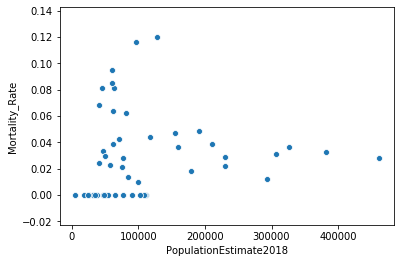

In [87]:
# Here we could limit our data around the densely packed region to decrease variability
# Visually, a good cutoff on the PopulationEstimate2018 axis could be 0.65e6 and we can train with this subset 
dense_ny_cases = ny_cases[ny_cases['PopulationEstimate2018'] < (0.65e6)]
sns.scatterplot(dense_ny_cases['PopulationEstimate2018'], ny_cases['Mortality_Rate'])

In [88]:
X_ny_pop, Y_ny_pop = process_data(ny_cases,population_stats,'Mortality_Rate')

In [89]:
# Fit the Linear Regression Model on these features (all columns have quantitative continuous data so no transformations needed)
ny_pop_model = LinearRegression(fit_intercept=True)
Y_ny_pop_pred, ny_pop_error, ny_pop_cv_error = test_models(ny_pop_model,X_ny_pop,Y_ny_pop)

# Training and CV Error
print("NY Population Stats RMSE: {}".format(ny_pop_error))
print("NY Population Stats CV RMSE: {}".format(ny_pop_cv_error))

NY Population Stats RMSE: 0.029906959244403637
NY Population Stats CV RMSE: 0.038582581159352064


In [90]:
X_ny_pop_dense, Y_ny_pop_dense = process_data(dense_ny_cases,population_stats,'Mortality_Rate')

In [91]:
# Fit the Linear Regression Model on these features (all columns have quantitative continuous data so no transformations needed)
ny_pop_model_dense = LinearRegression(fit_intercept=True)
Y_ny_pop_pred_dense, ny_pop_error_dense, ny_pop_cv_error_dense = test_models(ny_pop_model_dense,X_ny_pop_dense,Y_ny_pop_dense)

# Training and CV Error
print("NY Population Stats Dense RMSE: {}".format(ny_pop_error_dense))
print("NY Population Stats Dense CV RMSE: {}".format(ny_pop_cv_error_dense))

NY Population Stats Dense RMSE: 0.03141861549440926
NY Population Stats Dense CV RMSE: 0.04069709958174511


Based on the errors, we can see that the constraint of just focusing on the densely packed data was not that helpful in improving accuracy so our original data set should be the better set to use. 

### At Risk Populations

#### California

In [92]:
X_ca_risk, Y_ca_risk = process_data(ca_cases, at_risk, 'Mortality_Rate')

In [93]:
ca_at_risk_model = LinearRegression(fit_intercept=True)
Y_ca_risk_pred, ca_risk_error, ca_risk_cv_error = test_models(ca_at_risk_model, X_ca_risk, Y_ca_risk)
print("CA At Risk Population RMSE: {}".format(ca_risk_error))
print("CA At Risk Population CV RMSE: {}".format(ca_risk_cv_error))

CA At Risk Population RMSE: 0.12672811832635222
CA At Risk Population CV RMSE: 0.11393772333294519


In [94]:
X_ca_risk_no_outlier, Y_ca_risk_no_outlier = process_data(ca_cases_no_outlier, at_risk, 'Mortality_Rate')

In [95]:
ca_at_risk_model_no_outlier = LinearRegression(fit_intercept=True)
Y_ca_risk_pred_no_outlier, ca_risk_error_no_outlier, ca_risk_cv_error_no_outlier = test_models(ca_at_risk_model_no_outlier, X_ca_risk_no_outlier, Y_ca_risk_no_outlier)
print("CA At Risk Population RMSE: {}".format(ca_risk_error_no_outlier))
print("CA At Risk Population CV RMSE: {}".format(ca_risk_cv_error_no_outlier))

CA At Risk Population RMSE: 0.02100400319106507
CA At Risk Population CV RMSE: 0.025902789533464345


#### New York

In [96]:
X_ny_risk, Y_ny_risk = process_data(ny_cases, at_risk, 'Mortality_Rate')

In [97]:
ny_at_risk_model = LinearRegression(fit_intercept=True)
Y_ny_risk_pred, ny_risk_error, ny_risk_cv_error = test_models(ny_at_risk_model, X_ny_risk, Y_ny_risk)
print("NY At Risk Population RMSE: {}".format(ny_risk_error))
print("NY At Risk Population CV RMSE: {}".format(ny_risk_cv_error))

NY At Risk Population RMSE: 0.02992139393464591
NY At Risk Population CV RMSE: 0.035904710406989115


In [98]:
X_ny_risk_dense, Y_ny_risk_dense = process_data(dense_ny_cases, at_risk, 'Mortality_Rate')

In [99]:
ny_at_risk_model_dense = LinearRegression(fit_intercept=True)
Y_ny_risk_pred_dense, ny_risk_error_dense, ny_risk_cv_error_dense = test_models(ny_at_risk_model_dense, X_ny_risk_dense, Y_ny_risk_dense)
print("NY At Risk Population DenseRMSE: {}".format(ny_risk_error_dense))
print("NY At Risk Population Dense CV RMSE: {}".format(ny_risk_cv_error_dense))

NY At Risk Population DenseRMSE: 0.030120308781594513
NY At Risk Population Dense CV RMSE: 0.03844410049415323


### Infrastructure

#### California

In [100]:
X_ca_infrastructure, Y_ca_infrastructure = process_data(ca_cases, infrastructure, 'Mortality_Rate')

In [101]:
ca_infrastructure_model = LinearRegression(fit_intercept=True)
Y_ca_infrastructure_pred, ca_infrastructure_error, ca_infrastructure_cv_error = test_models(ca_infrastructure_model, X_ca_infrastructure, Y_ca_infrastructure)
print("CA Infrastructure RMSE: {}".format(ca_infrastructure_error))
print("CA Infrastructure CV RMSE: {}".format(ca_infrastructure_cv_error))

CA Infrastructure RMSE: 0.1311587792517802
CA Infrastructure CV RMSE: 0.13577454731605593


In [102]:
X_ca_infrastructure_no_outlier, Y_ca_infrastructure_no_outlier = process_data(ca_cases_no_outlier, infrastructure, 'Mortality_Rate')

In [103]:
ca_infrastructure_model_no_outlier = LinearRegression(fit_intercept=True)
Y_ca_infrastructure_pred_no_outlier, ca_infrastructure_error_no_outlier, ca_infrastructure_cv_error_no_outlier = test_models(ca_infrastructure_model_no_outlier, X_ca_infrastructure_no_outlier, Y_ca_infrastructure_no_outlier)
print("CA Infrastructure with Outliers RMSE: {}".format(ca_infrastructure_error_no_outlier))
print("CA Infrastructure with Outliers CV RMSE: {}".format(ca_infrastructure_cv_error_no_outlier))

CA Infrastructure with Outliers RMSE: 0.02451740142664268
CA Infrastructure with Outliers CV RMSE: 0.03860164328031655


#### New York

In [104]:
X_ny_infrastructure, Y_ny_infrastructure = process_data(ny_cases, infrastructure, 'Mortality_Rate')

In [105]:
ny_infrastructure_model = LinearRegression(fit_intercept=True)
Y_ny_infrastructure_pred, ny_infrastructure_error, ny_infrastructure_cv_error = test_models(ny_infrastructure_model, X_ny_infrastructure, Y_ny_infrastructure)
print("NY Infrastructure RMSE: {}".format(ny_infrastructure_error))
print("NY Infrastructure CV RMSE: {}".format(ny_infrastructure_cv_error))

NY Infrastructure RMSE: 0.029293765125863694
NY Infrastructure CV RMSE: 0.0308865834738834


In [106]:
X_ny_infrastructure_dense, Y_ny_infrastructure_dense = process_data(dense_ny_cases, infrastructure, 'Mortality_Rate')

In [107]:
ny_infrastructure_model_dense = LinearRegression(fit_intercept=True)
Y_ny_infrastructure_pred_dense, ny_infrastructure_error_dense, ny_infrastructure_cv_error_dense = test_models(ny_infrastructure_model_dense, X_ny_infrastructure_dense, Y_ny_infrastructure_dense)
print("NY Infrastructure Dense RMSE: {}".format(ny_infrastructure_error_dense))
print("NY Infrastructure Dense CV RMSE: {}".format(ny_infrastructure_cv_error_dense))

NY Infrastructure Dense RMSE: 0.03037165512537072
NY Infrastructure Dense CV RMSE: 0.034493368765073765


### Compare Linear Regression Models

In [108]:
x_labels = ['Population Stats', 'Population Stats No Outlier','At Risk Populations','At Risk Populations No Outlier','Infrastructure','Infrastructure No Outlier']
training_err = [ca_pop_error, ca_pop_error_no_outlier, ca_risk_error, ca_risk_error_no_outlier, ca_infrastructure_error, ca_infrastructure_error_no_outlier]
cv_err = [ca_pop_cv_error, ca_pop_cv_error_no_outlier, ca_risk_cv_error, ca_risk_cv_error_no_outlier, ca_infrastructure_cv_error, ca_infrastructure_cv_error_no_outlier]
cal_fig = go.Figure([
        go.Bar(x = x_labels, y = training_err, name='Training RMSE'),
        go.Bar(x = x_labels, y = cv_err, name='CV RMSE')])
cal_fig.update_layout(
        title = 'Compare Linear Regression Models for California Mortality Rate',
        xaxis_title='Models',
        yaxis_title='RMSE')

Based on the bars above we can see that in the case of population statistics the no outlier case has been improving most scores across the board so that may be a good set to focus on and we can conclude that all three of these metrics are good measures of mortality rate. 

In [109]:
x_labels = ['Population Stats', 'Population Stats Dense','At Risk Populations','At Risk Populations Dense','Infrastructure','Infrastructure Dense']
training_err = [ny_pop_error, ny_pop_error_dense, ny_risk_error, ny_risk_error_dense, ny_infrastructure_error, ny_infrastructure_error_dense]
cv_err = [ny_pop_cv_error, ny_pop_cv_error_dense, ny_risk_cv_error, ny_risk_cv_error_dense, ny_infrastructure_cv_error, ny_infrastructure_cv_error_dense]
ny_fig = go.Figure([
        go.Bar(x = x_labels, y = training_err, name='Training RMSE'),
        go.Bar(x = x_labels, y = cv_err, name='CV RMSE')])
ny_fig.update_layout(
        title = 'Compare Linear Regression Models for New York Mortality Rate',
        xaxis_title='Models',
        yaxis_title='RMSE')


The no outlier case does not seem to be useful here, so we can deduce that dense groups of the CA and NY data is not a good method of removing anomalies. 

### State Level Comparison

Our exploration can be on the Mortality Rate. We want to explore what are the features specifically of states that lead to the given mortality rate. As we saw above, there is a lot of missing data in terms of hospitalization in countries other than the US (which could be a helpful metric later on), so we can focus on the US. The map below explores whether or not the geography of the US has anything to do with the mortality rate.

Text(66.375, 0.5, 'Latitude')

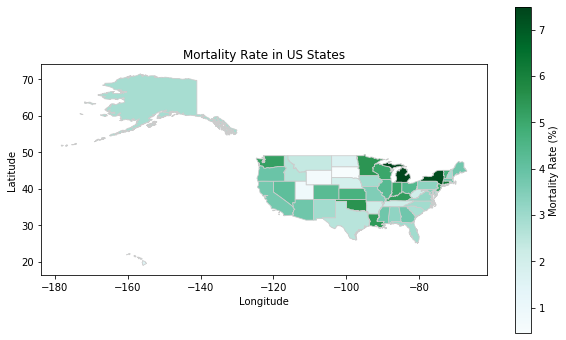

In [110]:
US_States = states[states['Country_Region'] == 'US']
US_States.drop(116, axis=0,inplace=True)
US_States.drop(['Recovered','Active','FIPS','ISO3','Last_Update','Country_Region'],axis=1,inplace=True)
US_states = states[['Province_State','Mortality_Rate']]

fp = './img/states.shp'
US_Map = gpd.read_file(fp)
US_Map = US_Map.rename(columns={'STATE_NAME':'Province_State'})
merged = US_Map.merge(US_states, on='Province_State')
rate_min = merged['Mortality_Rate'].min()
rate_max = merged['Mortality_Rate'].max()

metric = 'Mortality_Rate'
fig, ax = plt.subplots(figsize = (10,6))
merged.plot(column=metric,cmap='BuGn',linewidth=0.8,ax=ax,edgecolor='0.8')
sm = plt.cm.ScalarMappable(cmap='BuGn', norm=plt.Normalize(vmin=rate_min, vmax=rate_max))
sm._A = []
cbar = fig.colorbar(sm, label='Mortality Rate (%)')
# fig.savefig(map_export.png’, dpi=300)
plt.title('Mortality Rate in US States')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

### Features
We consider whether differences in when Pandemic Policies were have correlation with mortality rate. Upon inspection, there is no clear correlation and so we discard the feature.

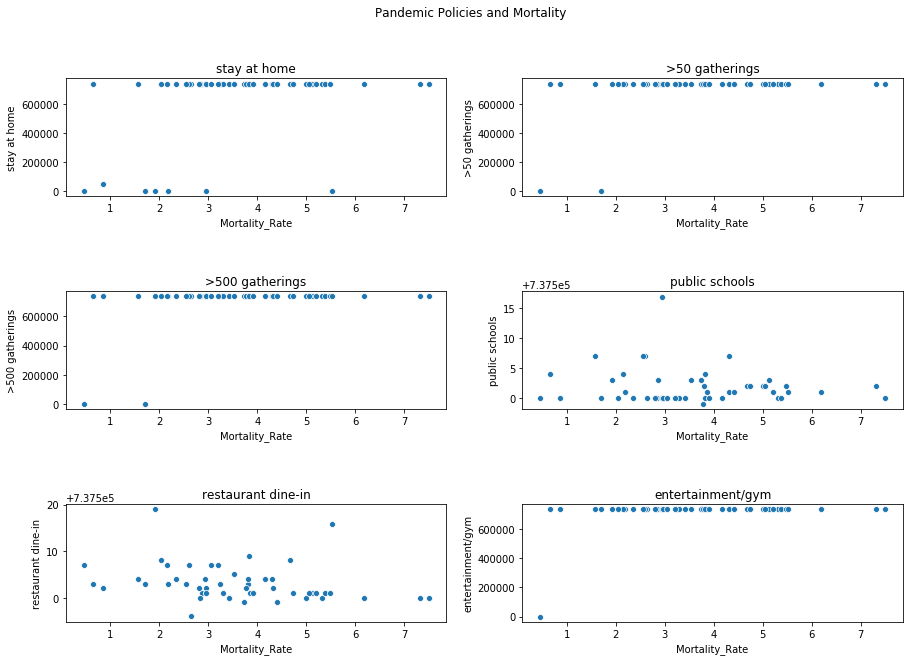

In [143]:
policies = ['stay at home', '>50 gatherings', '>500 gatherings', 'public schools', 'restaurant dine-in', 'entertainment/gym']
fig, axes = plt.subplots(nrows = 3, ncols = 2)
fig.subplots_adjust(hspace = 0.8)
fig.set_size_inches(15,10)
fig.suptitle('Pandemic Policies and Mortality')
for ax, feature in zip(axes.flatten(), policies):
    sns.scatterplot(state_cases['Mortality_Rate'], state_cases[feature] , ax = ax)
    ax.set(title= feature)

### Feature Correlations
Next we examine the correlations between features and with mortality rate.

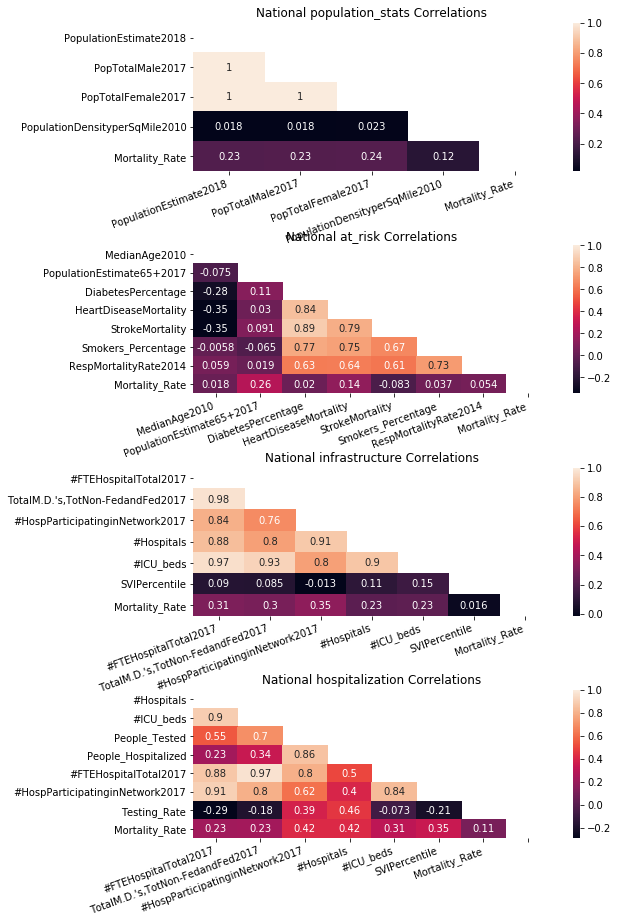

In [112]:
# add in on for
hospitalization = ['#Hospitals', '#ICU_beds','People_Tested', 'People_Hospitalized', '#FTEHospitalTotal2017', '#HospParticipatinginNetwork2017','Testing_Rate','Mortality_Rate']
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1, figsize=(8, 15))
sns.heatmap(state_cases[population_stats].corr(), ax = ax1, annot=True, mask = np.triu (state_cases[population_stats].corr())).set_title('National population_stats Correlations')
sns.heatmap(state_cases[at_risk].corr(), ax = ax2, annot=True, mask = np.triu(state_cases[at_risk].corr())).set_title('National at_risk Correlations')
sns.heatmap(state_cases[infrastructure].corr(), ax = ax3, annot=True, mask = np.triu(state_cases[infrastructure].corr())).set_title('National infrastructure Correlations')
sns.heatmap(state_cases[hospitalization].corr(), ax = ax4, annot=True, mask = np.triu(state_cases[hospitalization].corr())).set_title('National hospitalization Correlations')
fig.subplots_adjust(hspace = 0.5, wspace = 0.5)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=20, horizontalalignment='right');
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=20, horizontalalignment='right');
ax3.set_xticklabels(ax3.get_xticklabels(), rotation=20, horizontalalignment='right');
ax4.set_xticklabels(ax3.get_xticklabels(), rotation=20, horizontalalignment='right');

#### Population Stats 

In [113]:
X_states_pop, Y_states_pop = process_data(state_cases, population_stats, 'Mortality_Rate')

In [114]:
population_states_model = LinearRegression(fit_intercept=True)
Y_states_pop_pred, pop_error, pop_cv_error = test_models(population_states_model, X_states_pop,Y_states_pop)
print("States Poplation RMSE: {}".format(pop_error))
print("States Poplation CV RMSE: {}".format(pop_cv_error))

States Poplation RMSE: 1.35222902188139
States Poplation CV RMSE: 1.5701858895282927


#### At Risk

In [115]:
X_states_risk, Y_states_risk = process_data(state_cases, at_risk, 'Mortality_Rate')

In [116]:
risk_states_model = LinearRegression(fit_intercept=True)
Y_states_risk_pred, risk_error, risk_cv_error = test_models(risk_states_model, X_states_risk, Y_states_risk)
print("States At Risk RMSE: {}".format(risk_error))
print("States At Risk CV RMSE: {}".format(risk_cv_error))

States At Risk RMSE: 1.338251969817628
States At Risk CV RMSE: 1.6792806240395197


#### Infrastructure

In [117]:
X_states_infrastructure, Y_states_infrastructure = process_data(state_cases, infrastructure, 'Mortality_Rate')

In [118]:
infrastructure_states_model = LinearRegression(fit_intercept=True)
Y_states_infrastructure_pred, infrastructure_error, infrastructure_cv_error = test_models(infrastructure_states_model, X_states_infrastructure, Y_states_infrastructure)
print("States Infrastructure RMSE: {}".format(infrastructure_error))
print("States Infrastructure CV RMSE: {}".format(infrastructure_cv_error))

States Infrastructure RMSE: 1.3345662307547146
States Infrastructure CV RMSE: 1.55139480701033


#### Hospitals

In [119]:
state_cases.columns
hospitalization = ['#Hospitals', '#ICU_beds','People_Tested', 'People_Hospitalized', '#FTEHospitalTotal2017', '#HospParticipatinginNetwork2017','Testing_Rate','Mortality_Rate']

In [120]:
X_hospital, Y_hospital = process_data(state_cases, hospitalization,'Mortality_Rate')

In [121]:
hospital_model = LinearRegression(fit_intercept=True)
Y_hospital_pred, hospital_error, hospital_cv_error = test_models(hospital_model,X_hospital,Y_hospital)
print("CA Infrastructure RMSE: {}".format(ca_infrastructure_error))
print("CA Infrastructure CV RMSE: {}".format(ca_infrastructure_cv_error))

CA Infrastructure RMSE: 0.1311587792517802
CA Infrastructure CV RMSE: 0.13577454731605593


### Comparing State Linear Regression Models

In [122]:
x_labels = ['Population Stats','At Risk Populations','Infrastructure','Hospitals']
training_err = [pop_error, risk_error, infrastructure_error, hospital_error]
cv_err = [pop_cv_error, risk_cv_error, infrastructure_cv_error, hospital_cv_error]

states_fig = go.Figure([
        go.Bar(x = x_labels, y = training_err, name='Training RMSE'),
        go.Bar(x = x_labels, y = cv_err, name='CV RMSE')])
states_fig.update_layout(
        title = 'Compare Linear Regression Models for States Mortality Rate',
        xaxis_title='Models',
        yaxis_title='RMSE')

The added feature for hospitalization is not that helpful in predicting the mortality rate as compared to what we already have. Looks like infrastructure is our strongest asset here. 

### Applying County Models on a State Level

Based on our models above we can see if NY or California are good indicators for what happens in terms of Mortality Rate on a state wide level. 

Within each comparator model (with outliers and without) we have chosen the model with the smallest RMSE score.

In [123]:
ca_pop_compare_pred = ca_pop_model_no_outlier.predict(X_states_pop)
ca_pop_compare_error = rmse(ca_pop_compare_pred, Y_states_pop)
print("Model Error in Cal Population on States: {}".format(ca_pop_compare_error))

ny_pop_compare_pred = ny_pop_model_dense.predict(X_states_pop)
ny_pop_compare_error = rmse(ny_pop_compare_pred, Y_states_pop)
print("Model Error in NY Population on States: {}".format(ny_pop_compare_error))

Model Error in Cal Population on States: 3.835334185467395
Model Error in NY Population on States: 3.5568771116793223


In [124]:
ca_risk_compare_pred = ca_at_risk_model_no_outlier.predict(X_states_risk)
ca_risk_compare_error = rmse(ca_risk_compare_pred, Y_states_risk)
print("Model Error in Cal Risk on States: {}".format(ca_risk_compare_error))

ny_risk_compare_pred = ny_at_risk_model.predict(X_states_risk)
ny_risk_compare_error = rmse(ny_risk_compare_pred, Y_states_risk)
print("Model Error in NY Risk on States: {}".format(ny_risk_compare_error))

Model Error in Cal Risk on States: 3.941617227807976
Model Error in NY Risk on States: 3.6709073238925733


In [125]:
ca_inf_compare_pred = ca_infrastructure_model_no_outlier.predict(X_states_infrastructure)
ca_inf_compare_error = rmse(ca_inf_compare_pred, Y_states_infrastructure)
print("Model Error in Cal Infrastructure on States: {}".format(ca_inf_compare_error))

ny_inf_compare_pred = ny_infrastructure_model.predict(X_states_infrastructure)
ny_inf_compare_error = rmse(ny_inf_compare_pred, Y_states_infrastructure)
print("Model Error in NY Infrastructure on States: {}".format(ny_inf_compare_error))

Model Error in Cal Infrastructure on States: 3.9670764569672006
Model Error in NY Infrastructure on States: 3.5614418516553683


In [132]:
x_labels = ['CA Population Stats','NY Population Stats','CA At Risk Populations','NY At Risk Populations','CA Infrastructure','NY Infrastructure']
ca_training_err = [ca_pop_compare_error, ca_risk_compare_error, ca_inf_compare_error]
ny_training_err = [ny_pop_compare_error,ny_risk_compare_error, ny_inf_compare_error]

states_fig = go.Figure([
        go.Bar(x = x_labels, y = ny_training_err, name='New York'),
        go.Bar(x = x_labels, y =ca_training_err, name='California')])
states_fig.update_layout(
        title = 'Compare Linear Regression Models from Counties for States Mortality Rate',
        xaxis_title='Models',
        yaxis_title='RMSE')

New York seems to perform the best out of the two. But we can see that there is an error of minimum value around 3.5, which is not very good compared to the errors we had before, indicating that our hopes to generalize model behaviors may not have been fruitful.